In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device, "; cuda:", CUDA_VERSION)
print("torch:", TORCH_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: line 1: nvcc: command not found


/home/dhiya/Projects/env/image-captioning/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda:0 ; cuda: cu116
torch: 1.12
detectron2: 0.5


In [2]:
import torch, torchvision
import matplotlib.pyplot as plt
import json, cv2, glob
import numpy as np
from copy import deepcopy

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

In [4]:
data_path = 'dataset/Flicker8k_Dataset'

Shape: (220, 220, 3)


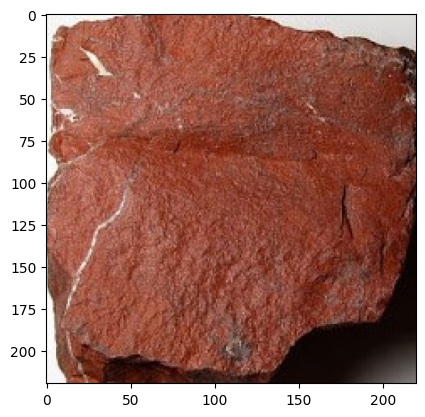

In [5]:
img1 = plt.imread(f'{data_path}/67.jpg')

print("Shape:", img1.shape)

# Detectron expects BGR images
img_bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
plt.imshow(img1)
plt.show()

Shape: (220, 220, 3)


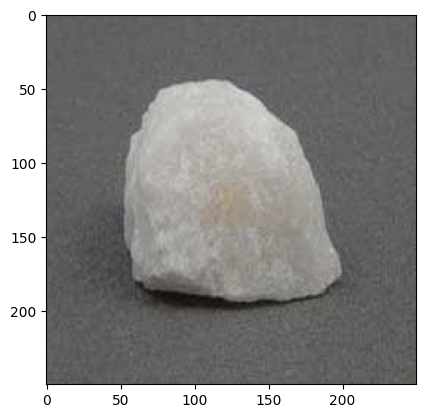

In [6]:
img2 = plt.imread(f'{data_path}/73.jpg')

print("Shape:", img1.shape)

# Detectron expects BGR images
img_bgr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
plt.imshow(img2)
plt.show()

In [8]:
train_filenames = glob.glob(data_path + "/*.jpg")

train_filenames.sort()

train_images = []
for img in train_filenames:
    img_read = plt.imread(img)
    img_bgr = cv2.cvtColor(img_read, cv2.COLOR_RGB2BGR)
    train_images.append(img_bgr)

    # # Show data image
    # print(img)
    # plt.imshow(imgs)
    # plt.show()

del img_read
del img_bgr
del train_filenames

print("train images length:", len(train_images))

train images length: 132


In [9]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    # cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

In [10]:
def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

model = get_model(cfg)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [11]:
model

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [12]:
def prepare_image_inputs(cfg, img_list):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images,model.backbone.size_divisibility)
    
    return images, batched_inputs

# Load all dataset images
images, batched_inputs = prepare_image_inputs(cfg, train_images)

# Load two dataset images
images, batched_inputs = prepare_image_inputs(cfg, [img_bgr1, img_bgr2])

/home/dhiya/Projects/env/image-captioning/lib/python3.10/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


In [13]:
len(images)

10

In [14]:
def get_features(model, images):
    features = model.backbone(images.tensor)
    return features

images = images.to(device)
features = get_features(model, images)

RuntimeError: CUDA out of memory. Tried to allocate 178.00 MiB (GPU 0; 11.75 GiB total capacity; 9.30 GiB already allocated; 61.31 MiB free; 9.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
features.keys()

dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])

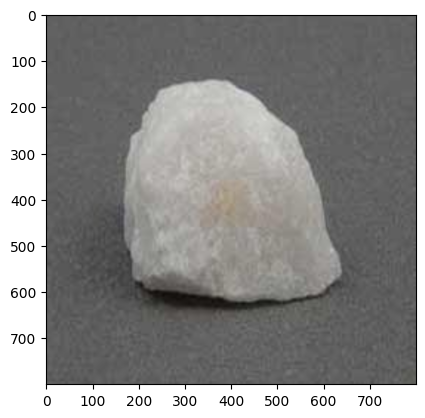

torch.Size([2, 256, 200, 200])


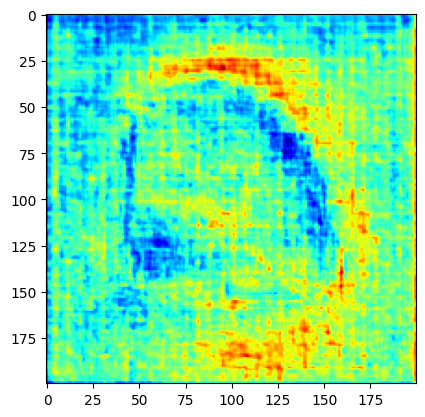

torch.Size([2, 256, 100, 100])


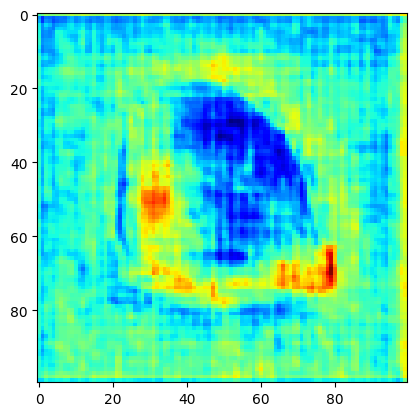

torch.Size([2, 256, 50, 50])


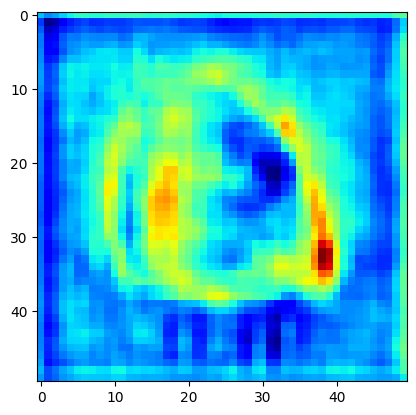

torch.Size([2, 256, 25, 25])


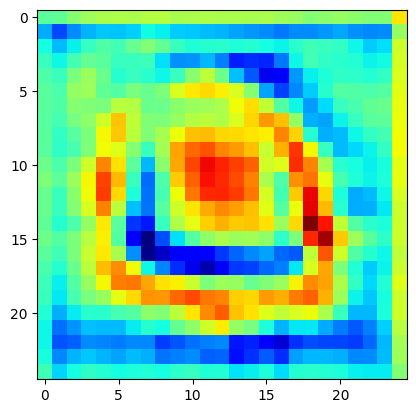

torch.Size([2, 256, 13, 13])


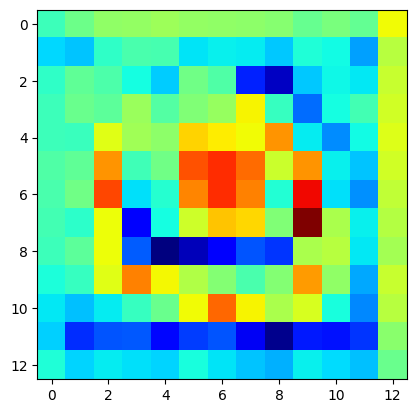

In [24]:
plt.imshow(cv2.resize(img2, (images.tensor.shape[-2:][::-1])))
plt.show()
for key in features.keys():
    print(features[key].shape)
    plt.imshow(features[key][1,0,:,:].squeeze().detach().cpu().numpy(), cmap='jet')
    plt.show()

In [15]:
def get_proposals(model, images, features):
    proposals, _ = model.proposal_generator(images, features)
    return proposals

proposals = get_proposals(model, images, features)

/home/dhiya/Projects/env/image-captioning/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)

    box_features = box_features.reshape(2, 1000, 1024) # depends on your config and batch size
    return box_features, features_list

box_features, features_list = get_box_features(model, features, proposals)

In [17]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas

pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)

In [18]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes

boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)

In [19]:
boxes

(tensor([[  1.8539,  27.9136, 798.8735,  ...,  44.5814, 802.7618, 776.5093],
         [ 13.8805,  52.7469, 755.7070,  ...,  49.4948, 739.1632, 773.0444],
         [ 16.6691,  53.3283, 785.2789,  ...,  69.7096, 799.3736, 777.1685],
         ...,
         [754.5271, 168.4075, 793.7837,  ..., 170.8961, 797.0629, 200.3829],
         [380.9828, 698.8468, 438.2663,  ..., 700.1503, 441.9390, 739.6426],
         [ 23.6334, 287.5186, 102.1204,  ..., 289.7524, 104.7572, 364.1710]],
        device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 tensor([[163.9098, 130.8758, 643.7074,  ..., 143.6233, 646.6091, 625.0864],
         [153.3264, 133.6941, 658.7897,  ..., 141.3958, 643.8396, 616.5728],
         [ 99.4992, 117.5405, 700.4938,  ..., 101.1189, 661.9904, 627.5109],
         ...,
         [185.0392, 165.6019, 254.8019,  ..., 166.4620, 257.2644, 253.3190],
         [169.6624, 216.5085, 206.6989,  ..., 215.9301, 208.5807, 303.0882],
         [425.3382, 178.9799, 500.2808,  ..., 181.7037, 501.551

In [20]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

In [21]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach()
    cls_boxes = output_boxes.tensor.detach().reshape(1000,80,4)
    max_conf = torch.zeros((cls_boxes.shape[0]))
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1]
        det_boxes = cls_boxes[:,cls_ind,:]
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh).cpu())
        max_conf[keep] = torch.where(cls_scores[keep].cpu() > max_conf[keep].cpu(), cls_scores[keep].cpu(), max_conf[keep].cpu())
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [22]:
temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
keep_boxes, max_conf = [],[]
for keep_box, mx_conf in temp:
    keep_boxes.append(keep_box)
    max_conf.append(mx_conf)

In [23]:
MIN_BOXES=10
MAX_BOXES=100
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
    return keep_boxes

keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]

In [24]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes.copy()]

visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]

In [25]:
visual_embeds

[tensor([[-0.4412, -0.8011,  0.0689,  ..., -2.0776, -0.2533,  1.0010],
         [ 0.4404,  0.2659, -0.6128,  ..., -1.8583,  0.0441,  0.5200],
         [-0.1734,  0.0427,  0.6519,  ..., -2.4127, -0.1069,  2.2233],
         ...,
         [ 0.5391, -1.1188, -0.4430,  ..., -2.2162, -1.8478,  1.3628],
         [ 0.6623, -0.4763, -0.7853,  ..., -2.0106,  0.4024,  1.1919],
         [ 1.2547,  0.6441,  0.1195,  ..., -0.3178, -0.5326, -1.1589]],
        device='cuda:0', grad_fn=<IndexBackward0>),
 tensor([[-0.2152, -0.9560,  0.4064,  ..., -0.7648, -1.7366,  2.0189],
         [ 2.2103,  0.2569,  0.9208,  ..., -1.2579, -0.0066,  1.0200],
         [ 2.0135,  0.5310,  1.4614,  ...,  0.3170, -0.3795,  0.4139],
         ...,
         [ 2.1379,  0.7876,  1.2615,  ...,  0.2152, -0.2879, -0.2888],
         [ 1.2660, -1.7403,  0.6073,  ..., -1.8292, -0.7673, -0.1570],
         [-0.2454, -0.1824,  0.5158,  ..., -0.0664, -0.9477,  1.6722]],
        device='cuda:0', grad_fn=<IndexBackward0>)]

In [26]:
from transformers import BertTokenizer, VisualBertForRegionToPhraseAlignment

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
models = VisualBertForRegionToPhraseAlignment.from_pretrained("uclanlp/visualbert-nlvr2-coco-pre")
models = models.to(device)

Some weights of VisualBertForRegionToPhraseAlignment were not initialized from the model checkpoint at uclanlp/visualbert-nlvr2-coco-pre and are newly initialized: ['attention.value.bias', 'attention.query.bias', 'attention.value.weight', 'attention.query.weight', 'attention.key.bias', 'attention.key.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
text = [
    "Singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas, batulumpur karbonatan, masif, retak-retak, sebagian hancur dan mulai lapuk",
    "Pecahan koral",
]
inputs = tokenizer(text, padding=True, truncation=True, max_length=50, return_tensors="pt")

In [60]:
inputs

{'input_ids': tensor([[    3, 11309,  1869, 11085, 24659,  5022,  2788,  1545,  2673,  2159,
         12157,  1476,  1497,  1580,  4361,    16,  2970,  6372,  3545, 29083,
          1476,    16, 27668,    16, 15388,    17, 15388,    16,  2469,  7051,
          1501,  2198,  2403,  1532,     4],
        [    3,  5328,  1939,  1483,     4,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1

In [44]:
input_ids = torch.tensor(inputs["input_ids"])
attention_mask = torch.tensor(inputs["attention_mask"])
token_type_ids = torch.tensor(inputs["token_type_ids"])

/tmp/ipykernel_82068/1576703520.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(inputs["input_ids"])
/tmp/ipykernel_82068/1576703520.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(inputs["attention_mask"])
/tmp/ipykernel_82068/1576703520.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(inputs["token_type_ids"])


In [45]:
visual_embeds = torch.stack(tuple(visual_embeds))
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
region_to_phrase_position = torch.ones((1, inputs["input_ids"].shape[-1] + visual_embeds.shape[-2])).type(torch.int64)

In [46]:
inputs.update(
    {
        "region_to_phrase_position": region_to_phrase_position,
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)
inputs = inputs.to(device)

In [47]:
labels = torch.ones(
    (1, inputs["input_ids"].shape[-1] + visual_embeds.shape[-2], visual_embeds.shape[-2])
)
labels = labels.to(device)

In [70]:
outputs = models(**inputs, labels=labels)

In [71]:
outputs

SequenceClassifierOutput(loss=tensor(62169.8906, device='cuda:0', grad_fn=<DivBackward0>), logits=tensor([[[-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         ...,
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619]],

        [[-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         ...,
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064]]],
       device='cud

In [72]:
loss = outputs.loss
scores = outputs.logits

print(loss)
print(scores)

tensor(62169.8906, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[[-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         ...,
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619],
         [-0.0610, -0.0646, -0.0666,  ..., -0.0613, -0.0676, -0.0619]],

        [[-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         ...,
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064],
         [-0.1147, -0.1034, -0.1134,  ..., -0.1138, -0.1122, -0.1064]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


In [53]:
pred = outputs["logits"].argmax(-1)

In [66]:
pred

tensor([[86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86,
         86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86,
         86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86,
         86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86,
         86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86,
         86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86,
         86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86,
         86, 86, 86, 86, 86, 86, 86, 86, 86],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1

In [55]:
outputs.keys()

odict_keys(['loss', 'logits'])

In [63]:
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(pred))

ValueError: only one element tensors can be converted to Python scalars

In [64]:
print(input_ids[pred])

IndexError: index 86 is out of bounds for dimension 0 with size 2